### Utpalraj Kemprai

### Importing the necessary libraries

In [ ]:
!pip install gdown

In [ ]:
import os
import zipfile
import numpy as np
from collections import defaultdict, Counter
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm as sparse_norm
from tqdm import tqdm
import gdown
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Linked to the corpus file

https://drive.google.com/file/d/1tLczapJIfVtRMU_-egB3rbiK60XaWIaQ/view?usp=drive_link

In [ ]:
file_id = '1tLczapJIfVtRMU_-egB3rbiK60XaWIaQ'

Corpus size

In [ ]:
corpus_size = 56528

### Downloading the corpus

In [ ]:
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'Corpus.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1tLczapJIfVtRMU_-egB3rbiK60XaWIaQ
From (redirected): https://drive.google.com/uc?id=1tLczapJIfVtRMU_-egB3rbiK60XaWIaQ&confirm=t&uuid=668b4a09-a27b-4ede-b77f-0d89ec7565a9
To: /kaggle/working/Corpus.zip
100%|██████████| 330M/330M [00:09<00:00, 34.3MB/s] 


'Corpus.zip'

### Extracting the content from the downloaded zipped files

In [ ]:
zip_path = "Corpus.zip"
extract_dir = "Corpus"

Function for extracting the zip file

In [ ]:
def extract_zip(zip_path, extract_dir):
  '''
  Extracts the zip file to the specified directory.

  Args:
    zip_path: The path to the zip file.
    extract_dir: The directory to extract the zip file to.
  '''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Extracting content from the zip file

In [ ]:
num_cores = multiprocessing.cpu_count()

with ProcessPoolExecutor(max_workers=num_cores) as executor:
  executor.submit(extract_zip, zip_path, extract_dir)

Deleting zip file after extracting it

In [ ]:
%rm Corpus.zip

Functions to read the corpus and store each document as a string in a list

In [ ]:
def read_file(filename):
    '''
    Reads a txt file and returns its content as a string.

    Args:
      filename: The path to the txt file.

    Returns:
      The content of the txt file as a string.
    '''
    with open(filename, 'r') as f:
        text_content = f.read()
    return str(text_content)

def read_files(directory):
    '''
    Reads all txt files in a directory and returns their contents as a list of strings.

    Args:
      directory: The path to the directory containing the txt files.

    Yields:
      The content of each txt file as a string.
    '''
    filenames = (os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt'))
    with ProcessPoolExecutor() as executor:
        # Using map to process files in parallel
        for result in tqdm(executor.map(read_file, filenames), total = corpus_size):
            yield result

Reading the corpus

In [ ]:
corpus = read_files('/kaggle/working/Corpus/Corpus')

Function to tokenize the corpus

In [ ]:
def tokenize_text(text):
    '''
    Tokenizes the given text.

    This function takes a string of text as input, and returns a list of tokens.
    The tokens are the individual "words" that make up the text, and are determined
    by the word_tokenize function from the NLTK library.

    The word_tokenize function splits the input text into individual words, based
    on spaces and punctuation.

    We then filter out any tokens that have fewer than three characters, since these
    are likely to be punctuation or other non-word tokens.

    The resulting list of tokens is returned as the output of the function.

    Args:
        text: The input text.

    Returns:
        A list of tokens.
  '''
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

In [ ]:
def preprocess_corpus(corpus):
  '''
  Preprocesses the corpus by applying the tokenize_text function to each document in parallel.

  Args:
    corpus: A list of documents.

  Returns:
    A list of preprocessed documents.
  '''
  with ProcessPoolExecutor() as executor:
    for result in tqdm(executor.map(tokenize_text, corpus), total=corpus_size):
       yield result


Tokenizing the corpus

In [ ]:
corpus = preprocess_corpus(corpus)

In [ ]:
corpus = tuple(corpus)

100%|██████████| 56528/56528 [05:04<00:00, 185.43it/s] 


Deleting the corpus after reading it

In [ ]:
%rm -rf /kaggle/working/Corpus/Corpus

### Implementing COALS algorithm (using ratio of probabilies instead of Correlation)

Function for building co-occurance matrix

In [ ]:
def build_cooccurrence_matrix(corpus, window_size=4, vocab_size=7000):
    '''
    This function takes a corpus (a list of documents) and builds a sparse co-occurrence matrix from it.
    The co-occurrence matrix is a matrix where the entry at row i and column j represents the ratio of
    p(common_word | word) by p(common_word | neighbor) for the i-th word and j-th word in the vocabulary.
    The window size is the number of words to the left and right of a word that we consider to be in the same window.
    The vocabulary is limited to the top `vocab_size` words in the corpus.

    The output of the function is a sparse matrix object, and a list of the words in the vocabulary.
    '''
    word_counts = Counter()
    # Co-occurrence counts for building the matrix
    cooccurrence_counts = defaultdict(lambda: defaultdict(int))

    # Iterate over each document in the corpus
    for document in tqdm(corpus):
        # Update the word counts with the words in the document
        word_counts.update(document)

        # Iterate over each word in the document
        for i, token in enumerate(document):
            # Get the range of indices for the words in the window
            start = max(0, i - window_size)
            end = min(len(document), i + window_size + 1)
            # Iterate over each word in the window
            for j in range(start, end):
                if i != j:  # Skip the current word
                    cooccurrence_counts[token][document[j]] += 1

    # Limit the vocabulary to the top `vocab_size` words
    vocab = [word for word, _ in word_counts.most_common(vocab_size)]

    # Most common word
    common_word = vocab[0]

    # Create a dictionary that maps words to their indices in the vocabulary
    vocab_index = {word: idx for idx, word in enumerate(vocab) if word in word_counts}

    # Build the sparse co-occurrence matrix
    row_idx, col_idx, data = [], [], []

    # Iterate over each word in the vocabulary
    for word, neighbors in cooccurrence_counts.items():
        if word in vocab_index:
            word_idx = vocab_index[word]
            # Probability of `common_word` given `word`
            p_common_word_given_word = cooccurrence_counts[word].get(common_word, 0) / word_counts[word] if word_counts[word] > 0 else 0

            for neighbor, count in neighbors.items():
                if neighbor in vocab_index:
                    neighbor_idx = vocab_index[neighbor]
                    # Probability of `common_word` given `neighbor`
                    p_common_word_given_neighbor = cooccurrence_counts[neighbor].get(common_word, 0) / word_counts[neighbor] if word_counts[neighbor] > 0 else 0

                    # Ensure probabilities are non-zero to avoid division errors
                    if p_common_word_given_word > 0 and p_common_word_given_neighbor > 0:
                        # Calculate the ratio of p(common_word | word) / p(common_word | neighbor)
                        ratio = p_common_word_given_word / p_common_word_given_neighbor
                        # Append to the sparse matrix data
                        row_idx.append(word_idx)
                        col_idx.append(neighbor_idx)
                        data.append(ratio)

    # Create a sparse matrix
    cooccurrence_matrix = csr_matrix((data, (row_idx, col_idx)), shape=(len(vocab), len(vocab)))

    return cooccurrence_matrix, vocab


Function for finding similar words based on cosine similarity

In [ ]:
def find_similar_words(semantic_space, vocab, word, top_n=5):
    """
    Find the top n words that are most similar to the given word in the semantic space.

    Args:
        semantic_space: The semantic space matrix.
        vocab (list): The list of words in the vocabulary.
        word (str): The word to find similar words for.
        top_n (int): The number of words to return.

    Returns:
        list: A list of tuples containing the word and the similarity score.
    """
    word_idx = vocab.index(word)
    vector = semantic_space.getrow(word_idx).toarray()  # Convert sparse row to dense array
    similarities = cosine_similarity(vector, semantic_space).flatten()
    # Get the indices of the most similar words
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    # Return a list of tuples containing the word and the similarity score
    return [(vocab[idx], similarities[idx]) for idx in similar_indices]

Function for identifying nouns and verbs related to Covid

In [ ]:
def identify_nouns_verbs(vocab, semantic_space, top_n=5):
    """
    Identifies the top n nouns and verbs in the given vocabulary.

    Args:
        vocab (list): The list of words in the vocabulary.
        top_n (int): The number of words to return for each part of speech.

    Returns:
        tuple: A tuple containing a list of the top n nouns and a list of the top n verbs.
    """
    # Tag the words with their parts of speech using the pso_tag function in nltk
    tagged_words = pos_tag([word for word in vocab])
    nouns = [word for word, pos in tagged_words if pos.startswith('NN')][:top_n]
    verbs = [word for word, pos in tagged_words if pos.startswith('VB')][:top_n]

    return nouns, verbs

Function for creating the semantic space

In [ ]:
def create_semantic_space(cooccurrence_matrix):
    """
    Create a semantic space from a co-occurrence matrix.

    The semantic space is created by normalizing the co-occurrence matrix
    by the L2 norm of each row. This is equivalent to weighting each word
    by its frequency in the corpus.

    Args:
        cooccurrence_matrix (csr_matrix): The co-occurrence matrix.

    Returns:
        csr_matrix: The semantic space matrix.
    """
    return cooccurrence_matrix.multiply(1 / sparse_norm(cooccurrence_matrix, axis=1))

Function for visualizing using Multi-Dimensional Scaling

In [ ]:
def visualize_with_mds(semantic_space, vocab, words_list, title):
    """
    Visualize the selected words in 2D space using Multi-Dimensional Scaling (MDS).

    Args:
        semantic_space (csr_matrix): The semantic space matrix.
        vocab (list): The list of words in the vocabulary.
        words_list (list): The list of words to visualize.
        title (str): The title of the plot.

    Returns:
        None
    """
    # Get the indices of the words in the vocabulary
    word_indices = [vocab.index(word) for word in words_list]

    # Convert the semantic space matrix to an array
    # This is necessary because MDS.fit_transform() expects a dense matrix
    semantic_space = semantic_space.toarray()

    # Get the semantic vectors of the words
    # The semantic vector of a word is the row in the semantic space matrix that corresponds to the word
    selected_vectors = semantic_space[word_indices]

    # Apply Multi-Dimensional Scaling (MDS)
    mds = MDS(n_components=2, random_state=14)
    coords = mds.fit_transform(selected_vectors)

    # Plot the words in 2D space
    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1])
    for i, word in enumerate(words_list):
        plt.text(coords[i, 0], coords[i, 1], word, fontsize=9)
    plt.title(title)
    plt.show()

### Creating the co-occurance matrix

In [ ]:
# Build co-occurrence matrix with limited vocabulary (~7,000)
cooccurrence_matrix, vocab = build_cooccurrence_matrix(corpus, window_size=4, vocab_size=7000)

100%|██████████| 56528/56528 [15:33<00:00, 60.57it/s]  


#### Most common word in the corpus

In [ ]:
vocab[0]

'patients'

### Creating the semantic space

In [ ]:
semantic_space = create_semantic_space(cooccurrence_matrix)

/tmp/ipykernel_37/2343050529.py:15: RuntimeWarning: divide by zero encountered in divide
  return cooccurrence_matrix.multiply(1 / sparse_norm(cooccurrence_matrix, axis=1))


### Displaying the vocabulary size and matrix size

In [ ]:
# Display vocabulary size and matrix size
print(f"Vocabulary Size: {len(vocab)}")
print(f"Co-occurrence Matrix Shape: {cooccurrence_matrix.shape}")

Vocabulary Size: 7000
Co-occurrence Matrix Shape: (7000, 7000)


### Identifying nouns and verbs relevant to COVID-19

In [ ]:
 # Identify nouns and verbs relevant to COVID-19
nouns, verbs = identify_nouns_verbs(vocab, semantic_space,top_n=10)
print(f"Nouns: {nouns}")
print(f"Verbs: {verbs}")

Nouns: ['patients', 'cells', 'data', 'virus', 'infection', 'disease', 'health', 'results', 'cell', 'time']
Verbs: ['study', 'using', 'used', 'protein', 'human', 'reported', 'found', 'associated', 'including', 'compared']


In [ ]:
nouns = ['patients', 'cells', 'data', 'virus', 'infection']
verbs = ['study', 'using', 'associated', 'reported', 'found']

### Finding words similar to selected nouns and pronouns

In [ ]:
 # Find similar words for selected nouns and verbs
for word in nouns + verbs:
    similar_words = find_similar_words(semantic_space, vocab, word)
    print(f"\nSimilar words for '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word} (cosine similarity: {similarity:.10f})")


Similar words for 'patients':
fig (cosine similarity: 0.9980910840)
test (cosine similarity: 0.9980283401)
coronavirus (cosine similarity: 0.9975796855)
virus (cosine similarity: 0.9975185117)
disease (cosine similarity: 0.9973905285)

Similar words for 'cells':
amino (cosine similarity: 0.9967164332)
induce (cosine similarity: 0.9932505369)
highly (cosine similarity: 0.9927825257)
lower (cosine similarity: 0.9927707025)
transcription (cosine similarity: 0.9922779045)

Similar words for 'data':
ratio (cosine similarity: 0.9964605804)
patients (cosine similarity: 0.9898841475)
inhibition (cosine similarity: 0.9887438938)
infection (cosine similarity: 0.9887260555)
management (cosine similarity: 0.9887026190)

Similar words for 'virus':
iii (cosine similarity: 0.9994245915)
factor (cosine similarity: 0.9986792047)
patients (cosine similarity: 0.9975185117)
influenza (cosine similarity: 0.9968736310)
sars (cosine similarity: 0.9965349389)

Similar words for 'infection':
control (cosine s

### Visualizing certain Covid concepts using multidimensional scaling

In [ ]:
pandemic_concepts = ['pandemic','virus','coronavirus','influenza']
vaccine_concepts = ['production','vaccine','mass','delivery']
quarantine_concepts = ['distancing','quarantine','travel','communities']

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


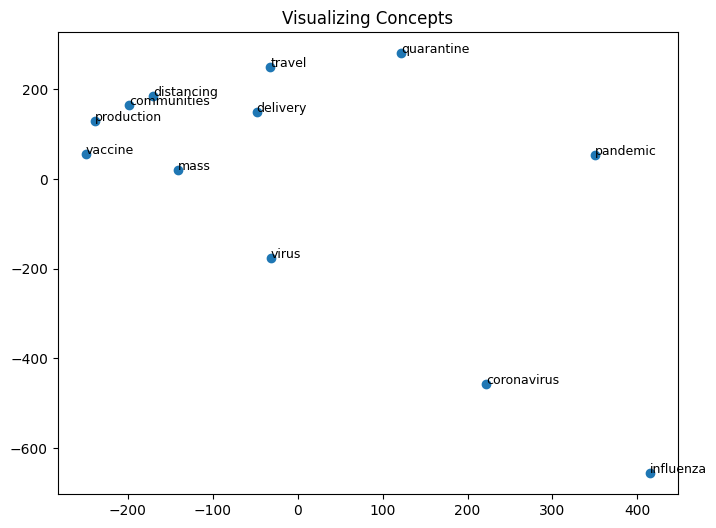

In [ ]:
concepts =  pandemic_concepts + vaccine_concepts + quarantine_concepts
visualize_with_mds(semantic_space, vocab, concepts, title = 'Visualizing Concepts')